In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing, linear_model
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import PolynomialFeatures, Normalizer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import holidays

%matplotlib inline

Класс моделей ARIMA недостаточно богат для наших данных: с их помощью, например, никак нельзя учесть взаимосвязи между рядами. Это можно сделать с помощью векторной авторегрессии VARIMA, но её питоновская реализация не позволяет использовать регрессионные признаки. Кроме того, авторегрессионный подход не позволяет учитывать, например, взаимодействия между сезонными компонентами. Вы могли заметить, что форма суточных сезонных профилей в будни и выходные немного разная; явно моделировать этот эффект с помощью ARIMA не получится.

Нам нужна более сложная модель. Давайте займёмся сведением задачи массового прогнозирования рядов к регрессионной постановке! Вам понадобится много признаков. Некоторые из них у вас уже есть — это:
<ol>
<li>идентификатор географической зоны
<li>дата и время
<li>количество поездок в периоды, предшествующие прогнозируемому
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
<li>Кроме того, не спешите выбрасывать построенный вами на прошлой неделе прогнозы — из них может получиться хороший признак для регрессии!
</ol>



Вы можете попробовать разные регрессионный модели, но хорошие результаты, скорее всего, дадут такие, которые будут позволять признакам взаимодействовать друг с другом.

Поскольку прогноз нужен на 6 часов вперёд, проще всего будет построить 6 независимых регрессионных моделей — одна для прогнозирования y^T+1|T, другая для y^T+2|T и т.д.

<ol>Чтобы сдать задание, выполните следующую последовательность действий.
<li>Для каждой из шести задач прогнозирования y^T+i|T,i=1,…,6 сформируйте выборки. Откликом будет yT+i при всевозможных значениях T, а признаки можно использовать следующие:
<ul>
<li>идентификатор географической зоны — категориальный
<li>год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так (done)
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA (done)
<li>сами значения прогнозов ARIMA y^T+i|TARIMA
<li>количество поездок из рассматриваемого района в моменты времени yT,yT−1,…,yT−K (параметр K можно подбирать; попробуйте начать, например, с 6)
<li>количество поездок из рассматриваемого района в моменты времени yT−24,yT−48,…,yT−24∗Kd (параметр Kd можно подбирать; попробуйте начать, например, с 2)
<li>суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
</ul>
Будьте внимательны при создании признаков — все факторы должны быть рассчитаны без использования информации из будущего: при прогнозировании y^T+i|T,i=1,…,6 вы можете учитывать только значения y до момента времени T включительно.

<li>Разбейте каждую из шести выборок на три части:

    обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
    тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
    итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016

<li>Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:

    допускала попарные взаимодействия между признаками
    была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)

<li>Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
Qmay=1R∗739∗6∑r=1R∑T=2016.04.3023:002016.05.3117:00∑i=16y^T|T+ir−yT+ir.
Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу Q, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.

<li>Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

<li>Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

<li>Загрузите ноутбук в форму.

Подгружаем данные

In [2]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# временные ряды для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
df.columns = regsDf.regId.values.astype('str')

In [3]:
df.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-06-30 19:00:00,116,190,135,132,395,308,401,336,496,260,...,2,44,4,297,311,104,9,142,96,1
2016-06-30 20:00:00,104,142,149,141,333,368,390,385,560,247,...,1,27,7,288,344,103,24,209,145,0
2016-06-30 21:00:00,151,162,145,135,359,422,460,541,672,259,...,2,21,9,287,307,185,9,213,142,1
2016-06-30 22:00:00,106,168,103,125,317,476,405,508,578,259,...,3,19,5,358,387,169,12,206,146,0
2016-06-30 23:00:00,85,130,86,113,256,428,483,531,631,210,...,9,0,7,323,110,147,38,173,119,0


In [14]:
# эта функция возвращает фичи, общие для всех колонок (временные гармоники, даты)
def getCommonFeature(Kw=5,Ka=2):
    #parameters:
    #  Kw is number of weeks harmonics
    #  Ka is number of annual harmonics

    us_holidays = holidays.UnitedStates(state="NY")
    df2 = pd.DataFrame(index=index1)
    df2 = df2.assign(linear = (df2.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    # категориальная переменная для выходных дней
    df2 = df2.assign(holidays = df2.index.date)
    df2.holidays =  df2.loc[:,'holidays'].apply(lambda x: 1 if x in us_holidays else 0)

    # час — эти признаки можно пробовать брать и категориальными
    # и непрерывными, можно даже и так, и так

    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        df2['weekCos'+str(ind)]= np.cos(np.pi*df2.linear*ind/168);
        df2['weekSin'+str(ind)]= np.sin(np.pi*df2.linear*ind/168);
    
    for ind in range(1,Ka+1):
        df2['yearCos'+str(ind)]= np.cos(2*np.pi*df2.linear*ind/8766);
        df2['yearSin'+str(ind)]= np.sin(2*np.pi*df2.linear*ind/8766);

    # добавляем числовое и категориальные свойства для дней недели
    df2 = df2.assign(dayOfWeek = df2.index.dayofweek)
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(df2.index.dayofweek),columns = ['dayOfWeek_'+str(x) for x in np.arange(6)],
               index = df2.index)      
    df2 = df2.merge(DoW,left_index=True,right_index=True)

    # добавляем dummy variables для месяца
    df2 = df2.assign(month = df2.index.month)
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(df2.index.month),columns = ['month_'+str(x) for x in np.arange(1,13)],
                  index = df2.index)      
    df2 = df2.merge(Months,left_index=True,right_index=True);

    # добавляем год (вещественный)
    df2 = df2.assign(year = df.index.year)

    # добавляем день месяца (вещественный)
    df2 = df2.assign(day = df.index.day)

    # добавляем час (вещественный и категориальный)
    df2 = df2.assign(hour = df.index.hour)
    lbHours = preprocessing.LabelBinarizer()
    lbHours.fit(list(np.arange(24)))
    Hours = pd.DataFrame(lbHours.transform(df2.index.hour),columns = ['hour_'+str(x) for x in np.arange(24)],
               index = df2.index)      
    df2 = df2.merge(Hours,left_index=True,right_index=True)
    return df2

In [12]:
# эта функция сохраняет данные в файл
def saveResults(rdf, fName, delta = 30):
    rnd = np.round

    f = open(fName,'w')
    f.writelines('id,y\n')

    for ind, row in rdf.reset_index().iterrows():
        historyStart = row.date

        if historyStart > datetime.datetime(2016,6,30,17):
            continue

        s0 = str(row.region)+'_'+ str(datetime.datetime.strftime(historyStart, "%Y-%m-%d"))+ '_'+ str(historyStart.hour)

        s1 = s0 +'_1,'+str(rnd(row.get('y1_pr'))+delta) + '\n'
        f.writelines(s1)

        s2 = s0 +'_2,'+str(rnd(row.get('y2_pr'))+delta) + '\n'
        f.writelines(s2)

        s3 = s0 +'_3,'+str(rnd(row.get('y3_pr'))+delta) + '\n'
        f.writelines(s3)

        s4 = s0 +'_4,'+str(rnd(row.get('y4_pr'))+delta) + '\n'
        f.writelines(s4)

        s5 = s0 +'_5,'+str(rnd(row.get('y5_pr'))+delta) + '\n'
        f.writelines(s5)

        s6 = s0 +'_6,'+str(rnd(row.get('y6_pr'))+delta) + '\n'
        f.writelines(s6)

    f.close()    

In [6]:
def processSeries(df,Kh = 6, Kp = 2):
    """
    Обработка одного данного ряда 
    parameters:
        df - начальный датафрейм, из которого выберем для обработки один ряд
        tReg - название ряда, который надо обработать
        Kh - количество отслеживаемых прошлых суточных лагов "назад"
        Kp - количество отслеживаемых прошлых периодических лагов (период 24 часа)

    """
 

    tDf = df.copy()
    for timeLag in np.arange(1,Kh+1):
        name = 'hourLag_'+str(timeLag)
        tDf.loc[:,name] = tDf.y.shift(periods=timeLag)

        

    for timeLag in np.arange(1,Kp+1):
        name = 'periodicLag_'+str(timeLag)
        tDf.loc[:,name] = tDf.y.shift(periods=timeLag*24)


    tDf.fillna(0,inplace=True)    

    # суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
    tDf.loc[:,'mean12'] = tDf.y.rolling(window = 12, min_periods = 1).mean()
    tDf.loc[:,'mean24'] = tDf.y.rolling(window = 24, min_periods = 1).mean()
    tDf.loc[:,'meanWeek'] = tDf.y.rolling(window = 168, min_periods = 1).mean()
    tDf.loc[:,'meanMonth'] = tDf.y.rolling(window = 720, min_periods = 1).mean()

    
     
    tDf.loc[:,'max12'] = tDf.y.rolling(window = 12, min_periods = 1).max()
    tDf.loc[:,'max24'] = tDf.y.rolling(window = 24, min_periods = 1).max()
    tDf.loc[:,'maxWeek'] = tDf.y.rolling(window = 168, min_periods = 1).max()
    tDf.loc[:,'maxMonth'] = tDf.y.rolling(window = 720, min_periods = 1).max()

    
    
    tDf.loc[:,'min12'] = tDf.y.rolling(window = 12, min_periods = 1).min()
    tDf.loc[:,'min24'] = tDf.y.rolling(window = 24, min_periods = 1).min()
    tDf.loc[:,'minWeek'] = tDf.y.rolling(window = 168, min_periods = 1).min()
    tDf.loc[:,'minMonth'] = tDf.y.rolling(window = 720, min_periods = 1).min()

        
    return tDf

In [7]:
# вычисление ошибки
def calcMAE(inpDf):
    score = 0
    testDf = inpDf.reset_index()
    for k, v in saveDict.iteritems():
        score += MAE(testDf.loc[:,k],testDf.loc[:,v])
    score = score / 6.0    
    print score

In [8]:
# create multyindex dataframe
index1 = df.index # time is first index
index2 = df.columns.values.astype(int)

mIndex = pd.MultiIndex.from_product([index2, index1],names=['region','date'])
df_test = pd.DataFrame(columns=['y'],index = mIndex)

In [9]:
idx = pd.IndexSlice

In [10]:
# create MultiIndex dataframe with target variables    
for k in index2:
    pos = idx[k,:]
    df_test.loc[idx[k,:],'y'] = df.loc[:,str(k)].values
    # create target variables
    df_test.loc[pos,'y1'] = df_test.loc[pos,'y'].shift(-1).fillna(0)
    df_test.loc[pos,'y2'] = df_test.loc[pos,'y'].shift(-2).fillna(0)
    df_test.loc[pos,'y3'] = df_test.loc[pos,'y'].shift(-3).fillna(0)
    df_test.loc[pos,'y4'] = df_test.loc[pos,'y'].shift(-4).fillna(0)
    df_test.loc[pos,'y5'] = df_test.loc[pos,'y'].shift(-5).fillna(0)
    df_test.loc[pos,'y6'] = df_test.loc[pos,'y'].shift(-6).fillna(0)
    
df_test.head()    

y     y1     y2    y3    y4    y5    y6
region date                                                          
1075   2014-01-01 00:00:00   87   92.0  108.0  77.0  47.0  22.0  10.0
       2014-01-01 01:00:00   92  108.0   77.0  47.0  22.0  10.0  18.0
       2014-01-01 02:00:00  108   77.0   47.0  22.0  10.0  18.0  19.0
       2014-01-01 03:00:00   77   47.0   22.0  10.0  18.0  19.0  28.0
       2014-01-01 04:00:00   47   22.0   10.0  18.0  19.0  28.0  37.0

In [52]:
# create common features
commonFeatures = getCommonFeature()
commonFeatures.index.name = 'date'
commonFeatures.head()

,linear,holidays,weekCos1,weekSin1,weekCos2,weekSin2,weekCos3,weekSin3,weekCos4,weekSin4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.0,1,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2014-01-01 01:00:00,1.0,1,0.999825,0.018699,0.999301,0.037391,0.998427,0.056070,0.997204,0.074730,...,0,0,0,0,0,0,0,0,0,0
2014-01-01 02:00:00,2.0,1,0.999301,0.037391,0.997204,0.074730,0.993712,0.111964,0.988831,0.149042,...,0,0,0,0,0,0,0,0,0,0
2014-01-01 03:00:00,3.0,1,0.998427,0.056070,0.993712,0.111964,0.985871,0.167506,0.974928,0.222521,...,0,0,0,0,0,0,0,0,0,0
2014-01-01 04:00:00,4.0,1,0.997204,0.074730,0.988831,0.149042,0.974928,0.222521,0.955573,0.294755,...,0,0,0,0,0,0,0,0,0,0


### Подгрузим и отобразим данные по погоде

In [53]:
weatherDf = pd.read_pickle('../data/weatherDf.pcl')
weatherDf.index.name = 'date'

In [54]:
weatherDf = weatherDf[~weatherDf.duplicated()]

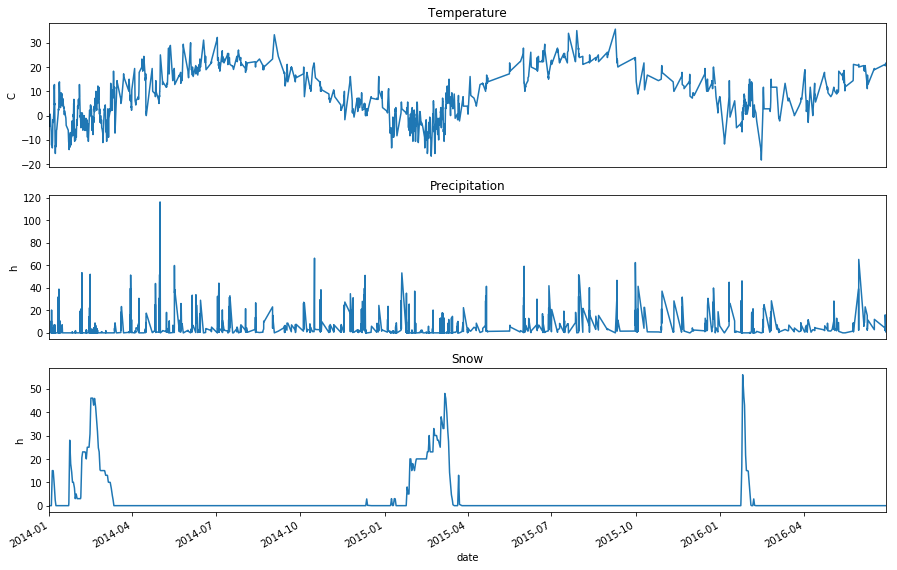

In [55]:
plt.figure(figsize=[15,10])

plt.subplot(311)
weatherDf.temp_val.plot()
plt.title('Temperature')
plt.xlabel('')
plt.ylabel('C')
plt.xticks([])

plt.subplot(312)
weatherDf.precip.plot()
plt.title('Precipitation')
plt.xlabel('')
plt.xticks([])
plt.ylabel('h')

plt.subplot(313)
weatherDf.snow.plot()
plt.title('Snow')
plt.ylabel('h')

In [56]:
commonFeatures = commonFeatures.merge(weatherDf,left_index=True,right_index=True,how='left')


In [58]:
commonFeatures[commonFeatures.duplicated()]

,linear,holidays,weekCos1,weekSin1,weekCos2,weekSin2,weekCos3,weekSin3,weekCos4,weekSin4,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,snow,precip,temp_val
date,,,,,,,,,,,,,,,,,,,,,


In [59]:
# join common features and add unique ones for each subgroup 
final = pd.DataFrame()
for k in index2:
    # create tatget variables
    pos = idx[k,:]
    tmp = processSeries(df_test.loc[pos,:].join(commonFeatures),Kh = 12, Kp = 4)
    final = pd.concat([final,tmp])

In [60]:
dropList = ['y1','y2','y3','y4','y5','y6','date','region'] # колонки, которые не надо учитывать в регрессоре
targetList= ['y1','y2','y3','y4','y5','y6']                # целевые переменные для регрессоров 

In [61]:
# define time frames
startTrain = '2014-01-01 00:00:00'
endTrain   = '2016-04-30 23:00:00'

startValidation = '2016-05-01 00:00:00'
endValidation   = '2016-05-31 23:00:00'

startTest = '2016-05-31 23:00:00'
endTest   = '2016-06-30 17:00:00'

In [62]:
# dataframe to save prediction
resIndex = pd.MultiIndex.from_product([final.index.levels[0],pd.date_range(start=startTest,end=endTest,freq='1H')],
                                    names=['region','date'])
df_res = pd.DataFrame(columns=['y1','y1_pr','y2','y2_pr','y3','y3_pr','y4','y4_pr','y5','y5_pr','y6','y6_pr'],index = resIndex)
df_res2 = pd.DataFrame(columns=['y1','y1_pr','y2','y2_pr','y3','y3_pr','y4','y4_pr','y5','y5_pr','y6','y6_pr'],index = resIndex)
saveDict = {'y1':'y1_pr','y2':'y2_pr','y3':'y3_pr','y4':'y4_pr','y5':'y5_pr','y6':'y6_pr'}

In [63]:
linReg = linear_model.Ridge()

In [64]:
# собственно, сам регрессор
for reg in final.index.levels[0].values:
    train = final.loc[idx[reg,startTrain:endValidation],:].reset_index()
    test  = final.loc[idx[reg,startTest:endTest],:].reset_index()
    for target in targetList:
        linReg.fit(train.drop(dropList,axis=1),train.loc[:,target])
        prediction = linReg.predict(test.drop(dropList,axis=1))
        prediction[prediction<0] = 0
        df_res.loc[idx[reg,:], target] = test.loc[:,target].values
        df_res.loc[idx[reg,:], saveDict.get(target)] = prediction
    print reg #,' ', calcMAE(df_res)    
df_res.head()        

1075
1076
1077
1125
1126
1127
1128
1129
1130
1131
1132
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1221
1222
1223
1224
1225
1227
1228
1229
1230
1231
1232
1233
1234
1235
1272
1273
1274
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1326
1327
1331
1332
1333
1334
1335
1336
1337
1338
1339
1376
1377
1378
1380
1382
1383
1384
1385
1386
1387
1388
1389
1390
1426
1431
1434
1435
1436
1437
1438
1439
1441
1442
1480
1482
1483
1530
1532
1533
1580
1630
1684
1733
1734
1783
2068
2069
2118
2119
2168


y1    y1_pr  y2    y2_pr  y3    y3_pr  y4  \
region date                                                             
1075   2016-05-31 23:00:00  26  22.8806  14  12.4812   5  6.25997   2   
       2016-06-01 00:00:00  14  15.4589   5  7.89784   2  4.21806   1   
       2016-06-01 01:00:00   5  7.16964   2  2.68461   1  4.33257   7   
       2016-06-01 02:00:00   2  1.52953   1  3.07932   7  8.60565  23   
       2016-06-01 03:00:00   1  5.93247   7  12.2287  23  26.7915  34   

                              y4_pr  y5    y5_pr  y6    y6_pr  
region date                                                    
1075   2016-05-31 23:00:00  6.85382   1  12.8791   7  21.7281  
       2016-06-01 00:00:00  7.39119   7  14.3476  23  30.3717  
       2016-06-01 01:00:00  10.3082  23  25.9345  34  49.8288  
       2016-06-01 02:00:00  23.7627  34  46.6673  72  76.2368  
       2016-06-01 03:00:00  48.0573  72  76.0202  54  73.3688

In [66]:
calcMAE(df_res)
#saveResults(df_res,fName='02Aug.csv',delta=0)

23.3480645994


На момент загрузки - 30е место в лидерборде со счётом 23.41763 (ник Frodos)

Теперь добавим нормализатор к регрессору.

In [ ]:
linReg = linear_model.Ridge()

ppl = Pipeline([('norm',MinMaxScaler()),('features',PolynomialFeatures(degree=2)),('regressor',linReg)])

for reg in final.index.levels[0].values:
    X_train = final.loc[idx[reg,startTrain:endValidation],:].reset_index().drop(dropList,axis=1)
    X_test  = final.loc[idx[reg,startTest:endTest],:].reset_index().drop(dropList,axis=1)
    
    for target in targetList:
        y_train = final.loc[idx[reg,startTrain:endValidation],:].reset_index().loc[:,target]
        y_test  = final.loc[idx[reg,startTest:endTest],:].reset_index().loc[:,target]
    
        ppl.fit(X_train,y_train)
        prediction = ppl.predict(X_test)
        prediction[prediction<0] = 0
        df_res2.loc[idx[reg,:], target] = y_test.values
        df_res2.loc[idx[reg,:], saveDict.get(target)] = prediction
    print reg #,' ', calcMAE(df_res)    
df_res2.head() 

calcMAE(df_res2)

1075
1076
1077


In [91]:
saveResults(df_res2,fName='13Aug.csv',delta=0)